# 1 Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from pandas.api.types import CategoricalDtype
from sklearn.model_selection import train_test_split

# forcing cells to output everything
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

# applying desired style for plots
plt.style.use('seaborn-whitegrid')

# printing the versions of python, numpy and pandas
from platform import python_version
print('Python version: ' + python_version())
print('Numpy version: ' + np.__version__)
print('Pamdas version: ' + pd.__version__)

Python version: 3.6.10
Numpy version: 1.18.1
Pamdas version: 1.0.3


# 2 Loading Data

## 2.1 CRSP Monthly Stock

In [2]:
# loading data with the CRSP stock information (incl. PERMNO and CUSIP code).
CRSP_monthly_stock_original = pd.read_csv('data/CRSP_MonthlyStock.csv', low_memory=False);

# create a working copy
CRSP_monthly_stock = CRSP_monthly_stock_original.copy()

CRSP_monthly_stock['date'] = pd.to_datetime(\
    CRSP_monthly_stock['date'], format='%Y/%m/%d')

# creating masks for the data frames to remove data out of date range
CRSP_monthly_stock_mask = (CRSP_monthly_stock['date'] >= pd.Timestamp('2010-1-1')) & \
    (CRSP_monthly_stock['date'] <= pd.Timestamp('2017-1-31'))
CRSP_monthly_stock = CRSP_monthly_stock.loc[CRSP_monthly_stock_mask]

# printing the dimensions of the data frame CRSP_monthly_stock
print('The data frame CRSP_monthly_stock consists of ' + \
      str(CRSP_monthly_stock.shape[0]) + ' rows and ' + \
      str(CRSP_monthly_stock.shape[1]) + ' columns.')

# assess null values of the data frame CRSP_monthly_stock
CRSP_monthly_stock_nans_share = CRSP_monthly_stock.isna().sum().sum() / \
    (CRSP_monthly_stock.shape[0] * CRSP_monthly_stock.shape[1])
print('The data frame CRSP_monthly_stock contains about ' + \
      str(round(CRSP_monthly_stock_nans_share * 100, 2)) + '% null values.')

# displaying the first few rows of the data frame CRSP_monthly_stock
CRSP_monthly_stock.head()

The data frame CRSP_monthly_stock consists of 594954 rows and 22 columns.
The data frame CRSP_monthly_stock contains about 13.89% null values.


,PERMNO,date,SHRCD,EXCHCD,SICCD,PRIMEXCH,TRDSTAT,PERMCO,HEXCD,HSICCD,...,HSICIG,BIDLO,ASKHI,PRC,VOL,SHROUT,CFACPR,CFACSHR,SPREAD,sprtrn
0,10001,2010-01-29,11.0,2.0,4925,A,A,7953,2,4925,...,NaN,9.86,10.5000,10.0600,3104.0,4361.0,1.0,1.0,NaN,-0.036974
1,10001,2010-02-26,11.0,2.0,4925,A,A,7953,2,4925,...,NaN,9.92,10.2201,10.0084,1510.0,4361.0,1.0,1.0,NaN,0.028514
2,10001,2010-03-31,11.0,2.0,4925,A,A,7953,2,4925,...,NaN,9.91,10.1800,10.1700,2283.0,4361.0,1.0,1.0,NaN,0.058796
3,10001,2010-04-30,11.0,2.0,4925,A,A,7953,2,4925,...,NaN,10.25,11.6100,11.3900,3350.0,6070.0,1.0,1.0,NaN,0.014759
4,10001,2010-05-28,11.0,2.0,4925,A,A,7953,2,4925,...,NaN,10.39,11.8000,11.4000,3451.0,6071.0,1.0,1.0,NaN,-0.081976


## 2.2 SP500 Company List

In [3]:
# loading S&P 500 company list
SP500_company_list = pd.read_csv('data/SP500_CompanyList.csv')

# printing the dimensions of the data frame SP500_company_list
print('The data frame SP500_company_list consists of ' + \
      str(SP500_company_list.shape[0]) + ' rows and ' + \
      str(SP500_company_list.shape[1]) + ' columns.')

# assess null values of the data frame SP500_company_list
SP500_company_list_nans_share = SP500_company_list.isna().sum().sum() / \
    (SP500_company_list.shape[0] * SP500_company_list.shape[1])
print('The data frame SP500_company_list contains about ' + \
      str(round(SP500_company_list_nans_share * 100, 2)) + '% null values.')

# displaying the first few rows of the data frame SP500_company_list
SP500_company_list.head()

The data frame SP500_company_list consists of 515 rows and 9 columns.
The data frame SP500_company_list contains about 0.0% null values.


,PERMNO,date,NCUSIP,TICKER,COMNAM,PERMCO,CUSIP,NWPERM,PRC
0,10104,29/06/2018,68389X10,ORCL,ORACLE CORP,8045,68389X10,0,44.06
1,10107,29/06/2018,59491810,MSFT,MICROSOFT CORP,8048,59491810,0,98.61
2,10138,29/06/2018,74144T10,TROW,T ROWE PRICE GROUP INC,8087,74144T10,0,116.09
3,10145,29/06/2018,43851610,HON,HONEYWELL INTERNATIONAL INC,22168,43851610,0,144.05
4,10516,29/06/2018,03948310,ADM,ARCHER DANIELS MIDLAND CO,20207,03948310,0,45.83


## 2.3 Checking if all S&P 500 companies are in the CRSP data set

### 2.3.1 Assessment of the Number of Unique Identifiers

In [4]:
# number of companies according to CUSIP and PERMNO in monthly stock df
print('There are ' + str(len(CRSP_monthly_stock['CUSIP'].unique())) + \
      ' unique CUSIP identifiers in CRSP_monthly_stock.')
print('There are ' + str(len(CRSP_monthly_stock['PERMNO'].unique())) + \
      ' unique PERMNO identifiers in CRSP_monthly_stock.\n')

# number of companies according to CUSIP and PERMNO in company list df
print('There are ' + str(len(SP500_company_list['CUSIP'].unique())) + \
      ' unique CUSIP identifiers in SP500_company_list.')
print('There are ' + str(len(SP500_company_list['PERMNO'].unique())) + \
      ' unique PERMNO identifiers in SP500_company_list.')

There are 10256 unique CUSIP identifiers in CRSP_monthly_stock.
There are 10256 unique PERMNO identifiers in CRSP_monthly_stock.

There are 515 unique CUSIP identifiers in SP500_company_list.
There are 515 unique PERMNO identifiers in SP500_company_list.


### 2.3.2 Assessment of the Differences of the two Data Frames

In [5]:
# make CUSIP codes strings
SP500_company_list['CUSIP'] = SP500_company_list['CUSIP'].astype(str)
CRSP_monthly_stock['CUSIP'] = CRSP_monthly_stock['CUSIP'].astype(str)

# checking if all s&p500 companies are in CRSP_monthly_stock file (using PERMNO code).
PERMNO_code_left = list(set(SP500_company_list['PERMNO']).\
                        difference(set(CRSP_monthly_stock['PERMNO'])))

# checking if all s&p500 companies are in CRSP_monthly_stock file (using CUSIP code).
CUSIP_code_left = list(set(SP500_company_list['CUSIP']).
                       difference(set(CRSP_monthly_stock['CUSIP'])))

print('There are ' + str(len(PERMNO_code_left)) + ' PERMNO codes that are' + \
      ' in the SP500_company_list but not in the CRSP_monthly_stock data frame.' + \
     str(PERMNO_code_left))

print('There are ' + str(len(CUSIP_code_left)) + \
      ' CUSIP codes that are in the SP500_company_list but not in the' + \
      ' CRSP_monthly_stock data frame:\n' + str(CUSIP_code_left))

There are 2 PERMNO codes that are in the SP500_company_list but not in the CRSP_monthly_stock data frame:
[16816, 16851]
There are 16 CUSIP codes that are in the SP500_company_list but not in the CRSP_monthly_stock data frame:
['40414L10', '87150310', '10922N10', '05493710', '98412160', '41387510', '12485710', '72027910', '12485720', '92936P10', '90130A20', '26078J10', '12550910', '89102710', '03748R10', '90130A10']


In [6]:
# looking at two permno codes not found in CRSP.
# since the data is sorted according to date we can look at the first observation found.
CRSP_monthly_stock_original[CRSP_monthly_stock_original['PERMNO'] == 16816].head(1)
CRSP_monthly_stock_original[CRSP_monthly_stock_original['PERMNO'] == 16851].head(1)

,PERMNO,date,SHRCD,EXCHCD,SICCD,PRIMEXCH,TRDSTAT,PERMCO,HEXCD,HSICCD,...,HSICIG,BIDLO,ASKHI,PRC,VOL,SHROUT,CFACPR,CFACSHR,SPREAD,sprtrn
230343,16816,2017/07/31,NaN,NaN,NaN,NaN,NaN,56000,3,9999,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019349


,PERMNO,date,SHRCD,EXCHCD,SICCD,PRIMEXCH,TRDSTAT,PERMCO,HEXCD,HSICCD,...,HSICIG,BIDLO,ASKHI,PRC,VOL,SHROUT,CFACPR,CFACSHR,SPREAD,sprtrn
231250,16851,2017/08/31,NaN,NaN,NaN,NaN,NaN,56027,1,5191,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000546


### 2.3.3 Assessment with regards to the SP500 Companies

In [7]:
# adding column to CRSP_monhtly_stock to indicate if company is in the S&P 500 index
in_sp500 = []
for stock in CRSP_monthly_stock['PERMNO'].tolist():
    in_sp500.append(stock in set(SP500_company_list['PERMNO'].tolist()))
    
CRSP_monthly_stock['in_sp500'] = in_sp500

In [8]:
print('There are ' + str(CRSP_monthly_stock['in_sp500'].isna().sum()) + \
      ' observations for which it is not known if the company is in the SP500 or not')

in_sp500_counter = Counter(CRSP_monthly_stock['in_sp500'])
in_sp500_percent = in_sp500_counter[True] / (in_sp500_counter[True] + in_sp500_counter[False])

print('Around ' + str(round(in_sp500_percent * 100)) + ' % of the companies are in the SP500.')

There are 0 observations for which it is not known if the company is in the SP500 or not.
Around 7 % of the companies are in the SP500.


### 2.3.4 Extract Identifier Codes

In [9]:
# exporting CUSIP code list as .txt file
with open('data/CUSIP_codes.txt', 'w') as cusip_codes:
    _ = cusip_codes.write(pd.Series(CRSP_monthly_stock['CUSIP'].unique()).to_string(index=False))

# exporting PERMNO code list as .txt file
with open('data/PERMNO_codes.txt', 'w') as cusip_codes:
    _ = cusip_codes.write(pd.Series(CRSP_monthly_stock['PERMNO'].unique()).to_string(index=False))
    
# exporting SIC code list as .txt file
with open('data/SIC_codes.txt', 'w') as cusip_codes:
    _ = cusip_codes.write(pd.Series(CRSP_monthly_stock['SICCD'].unique()).to_string(index=False))

## 2.4 Firm Level Financial Ratios

In [10]:
# loading financial ratio firm level data.
financial_ratios_firm_level = pd.read_csv('data/FinancialRatios_FirmLevel.csv')

# printing the dimensions of the data frame financial_ratios_firm_level
print('The data frame financial_ratios_firm_level consists of ' + \
      str(financial_ratios_firm_level.shape[0]) + ' rows and ' + \
      str(financial_ratios_firm_level.shape[1]) + ' columns.')

# assess null values of the data frame financial_ratios_firm_level
financial_ratios_firm_level_nans_share = financial_ratios_firm_level.isna().sum().sum() / \
    (financial_ratios_firm_level.shape[0] * financial_ratios_firm_level.shape[1])
print('The data frame financial_ratios_firm_level contains about ' + \
      str(round(financial_ratios_firm_level_nans_share * 100, 2)) + '% null values.')

# displaying the first few rows of the data frame financial_ratios_firm_level
financial_ratios_firm_level.head()

The data frame financial_ratios_firm_level consists of 315757 rows and 75 columns.
The data frame financial_ratios_firm_level contains about 10.31% null values.


,permno,adate,qdate,public_date,CAPEI,bm,evm,pe_op_basic,pe_op_dil,pe_exi,...,sale_nwc,rd_sale,adv_sale,staff_sale,accrual,ptb,PEG_trailing,DIVYIELD,PEG_1yrforward,PEG_ltgforward
0,10001,2008/12/31,2009/09/30,2010/01/31,22.503,0.850,5.945,10.702,10.702,13.237,...,100.077,0.0,0.0,0.0,0.135,1.395,NaN,5.37%,NaN,NaN
1,10001,2009/12/31,2009/12/31,2010/02/28,13.537,0.799,6.496,5.853,5.853,6.334,...,NaN,0.0,0.0,0.0,0.123,1.216,0.199,5.40%,NaN,NaN
2,10001,2009/12/31,2009/12/31,2010/03/31,13.756,0.799,6.496,5.947,5.947,6.437,...,NaN,0.0,0.0,0.0,0.123,1.235,0.202,5.31%,NaN,NaN
3,10001,2009/12/31,2009/12/31,2010/04/30,21.443,0.799,6.496,6.661,6.661,7.209,...,NaN,0.0,0.0,0.0,0.123,1.925,0.226,4.74%,NaN,NaN
4,10001,2009/12/31,2010/03/31,2010/05/31,22.817,0.900,5.013,5.969,5.969,6.590,...,NaN,0.0,0.0,0.0,0.038,1.245,0.140,4.74%,NaN,NaN


## 2.5 Long Term Credit Rating

In [11]:
# loading long term credit rating data.
long_term_credit_rating = pd.read_csv('data/LongTermCreditRating.csv', low_memory=False)

# printing the dimensions of the data frame long_term_credit_rating
print('The data frame long_term_credit_rating consists of ' + \
      str(long_term_credit_rating.shape[0]) + ' rows and ' + \
      str(long_term_credit_rating.shape[1]) + ' columns.')

# assess null values of the data frame long_term_credit_rating
long_term_credit_rating_nans_share = long_term_credit_rating.isna().sum().sum() / \
    (long_term_credit_rating.shape[0] * long_term_credit_rating.shape[1])
print('The data frame long_term_credit_rating contains about ' + \
      str(round(long_term_credit_rating_nans_share * 100, 2)) + '% null values.')

# displaying the first few rows of the data frame long_term_credit_rating
long_term_credit_rating.head()

The data frame long_term_credit_rating consists of 772457 rows and 15 columns.
The data frame long_term_credit_rating contains about 23.24% null values.


,gvkey,splticrm,datadate,addzip,city,county,ggroup,gind,gsector,idbflag,loc,spcsrc,state,ipodate,cusip
0,1003,NaN,2010/01/31,63125,St. Louis,NaN,2550.0,255040.0,25.0,D,USA,NaN,MO,NaN,000354100
1,1003,NaN,2010/02/28,63125,St. Louis,NaN,2550.0,255040.0,25.0,D,USA,NaN,MO,NaN,000354100
2,1003,NaN,2010/03/31,63125,St. Louis,NaN,2550.0,255040.0,25.0,D,USA,NaN,MO,NaN,000354100
3,1003,NaN,2010/04/30,63125,St. Louis,NaN,2550.0,255040.0,25.0,D,USA,NaN,MO,NaN,000354100
4,1003,NaN,2010/05/31,63125,St. Louis,NaN,2550.0,255040.0,25.0,D,USA,NaN,MO,NaN,000354100


## 2.6 US Treasury and Inflation

In [12]:
# loading data
US_treasury_and_inflation = pd.read_csv('data/US_Treasury_and_Inflation_Indexes.csv')

# printing the dimensions of the data frame US_treasury_and_inflation
print('The data frame US_treasury_and_inflation consists of ' + \
      str(US_treasury_and_inflation.shape[0]) + ' rows and ' + \
      str(US_treasury_and_inflation.shape[1]) + ' columns.')

# assess null values of the data frame US_treasury_and_inflation
US_treasury_and_inflation_nans_share = US_treasury_and_inflation.isna().sum().sum() / \
    (US_treasury_and_inflation.shape[0] * US_treasury_and_inflation.shape[1])
print('The data frame US_treasury_and_inflation contains about ' + \
      str(round(US_treasury_and_inflation_nans_share * 100, 2)) + '% null values.')

# displaying the first few rows of the data frame US_treasury_and_inflation
US_treasury_and_inflation.head()

The data frame US_treasury_and_inflation consists of 85 rows and 9 columns.
The data frame US_treasury_and_inflation contains about 0.0% null values.


,caldt,b1ret,b1ind,t90ret,t90ind,t30ret,t30ind,cpiret,cpiind
0,20100129,0.003246,1229.322,0.000062,964.5938,0.000028,792.7575,0.003417,509.9
1,20100226,-0.000473,1228.741,0.000015,964.6083,0.000010,792.7653,0.000249,510.0
2,20100331,-0.000869,1227.673,0.000042,964.6488,0.000068,792.8193,0.004106,512.1
3,20100430,0.000162,1227.872,0.000129,964.7732,0.000111,792.9073,0.001737,513.0
4,20100528,0.000695,1228.726,0.000129,964.8977,0.000112,792.9961,0.000775,513.4


## 2.7 Financial Ratios Industry Level


In [13]:
# loading data
financial_ratios_industry_level = pd.read_csv('data/FinancialRatios_IndustryLevel.csv')

# printing the dimensions of the data frame financial_ratios_industry_level
print('The data frame financial_ratios_industry_level consists of ' + \
      str(financial_ratios_industry_level.shape[0]) + ' rows and ' + \
      str(financial_ratios_industry_level.shape[1]) + ' columns.')

# assess null values of the data frame financial_ratios_industry_level
financial_ratios_industry_level_nans_share = financial_ratios_industry_level.isna().sum().sum() / \
    (financial_ratios_industry_level.shape[0] * financial_ratios_industry_level.shape[1])
print('The data frame financial_ratios_industry_level contains about ' + \
      str(round(financial_ratios_industry_level_nans_share * 100, 2)) + '% null values.')

# displaying the first few rows of the data frame financial_ratios_industry_level
financial_ratios_industry_level.head()

The data frame financial_ratios_industry_level consists of 855 rows and 76 columns.
The data frame financial_ratios_industry_level contains about 0.0% null values.


,public_date,gicdesc,NFIRM,indret_ew,indret_vw,dpr_Median,PEG_trailing_Median,bm_Median,CAPEI_Median,DIVYIELD_Median,...,rect_turn_Median,sale_equity_Median,sale_invcap_Median,sale_nwc_Median,accrual_Median,rd_sale_Median,adv_sale_Median,staff_sale_Median,PEG_1yrforward_Median,PEG_ltgforward_Median
0,2010/01/31,Communication Services,52,-0.071969,-0.080034,0.227,0.454,0.566,11.587,7.25%,...,9.905,1.641,0.749,8.094,0.101,0.0,0.003,0.000,-0.042,1.118
1,2010/01/31,Consumer Discretionary,606,-0.000817,-0.025503,0.000,0.220,0.630,11.491,2.14%,...,10.439,2.652,1.858,5.224,0.112,0.0,0.014,0.000,-0.041,0.835
2,2010/01/31,Consumer Staples,173,-0.018075,-0.010126,0.161,0.675,0.545,17.175,2.50%,...,11.303,3.085,1.995,7.297,0.065,0.0,0.006,0.000,0.226,1.317
3,2010/01/31,Energy,222,-0.021246,-0.045400,0.000,0.196,0.748,8.635,1.22%,...,5.456,0.973,0.518,4.166,0.135,0.0,0.000,0.000,-0.165,-0.078
4,2010/01/31,Financials,785,0.050111,0.002939,0.538,0.339,1.192,10.549,2.80%,...,0.092,0.682,0.358,2.632,0.014,0.0,0.007,0.222,-0.049,0.705


# 3 Merging the Data Frames

## 3.1 Preparations for Merging

### 3.1.1 Turning Dates into DateTime Objects

In [14]:
SP500_company_list['date'] = pd.to_datetime(\
    SP500_company_list['date'], format='%d/%m/%Y')

financial_ratios_firm_level['adate'] = pd.to_datetime(\
    financial_ratios_firm_level['adate'], format='%Y/%m/%d')

financial_ratios_firm_level['qdate'] = pd.to_datetime(\
    financial_ratios_firm_level['qdate'], format='%Y/%m/%d')

financial_ratios_firm_level['public_date'] = pd.to_datetime(\
    financial_ratios_firm_level['public_date'], format='%Y/%m/%d')

long_term_credit_rating['datadate'] = pd.to_datetime(\
    long_term_credit_rating['datadate'], format='%Y/%m/%d')

US_treasury_and_inflation['caldt'] = pd.to_datetime(\
    US_treasury_and_inflation['caldt'], format='%Y%m%d')

financial_ratios_industry_level['public_date'] = pd.to_datetime(\
    financial_ratios_industry_level['public_date'], format='%Y/%m/%d')

### 3.1.2 Removing Rows outside Date Range [2010.01.01, 2017.01.31]

In [15]:
# creating timestamps indicating the start and end of the interval
start_date, end_date = pd.Timestamp('2010-1-1'), pd.Timestamp('2017-1-31')

financial_ratios_firm_level_mask = (financial_ratios_firm_level['public_date'] >= \
    start_date) & (financial_ratios_firm_level['public_date'] <= end_date)

long_term_credit_rating_mask = (long_term_credit_rating['datadate'] >= \
    start_date) & (long_term_credit_rating['datadate'] <= end_date)

# remove the observations outside of the date range by applying the masks
financial_ratios_firm_level = financial_ratios_firm_level.loc[financial_ratios_firm_level_mask]
long_term_credit_rating = long_term_credit_rating.loc[long_term_credit_rating_mask]

### 3.1.3 Preparing Industry Data on Sectors for Merging

In [16]:
# looking at sector-variable values
print('The sector codes in long_term_credit_rating are the following:\n' + \
      str(long_term_credit_rating['gsector'].unique().tolist()) + '\n')
print('The sector codes in financial_ratios_industry_level are the following:\n' + \
      ', '.join(financial_ratios_industry_level['gicdesc'].unique().tolist()))

The sector codes in long_term_credit_rating are the following:
[25.0, 20.0, 45.0, 35.0, 10.0, 40.0, 55.0, 50.0, 60.0, nan, 15.0, 30.0]

The sector codes in financial_ratios_industry_level are the following:
Communication Services, Consumer Discretionary, Consumer Staples, Energy, Financials, Health Care, Industrials, Information Technology, Materials, Utilities, Real Estate


In [17]:
# substituting the numerical code with the desctiption.
long_term_credit_rating['gsector'] = \
long_term_credit_rating['gsector'].map({10.: 'Energy', \
                                        15.: 'Materials', \
                                        20.: 'Industrials', \
                                        25.: 'Consumer Discretionary', \
                                        30.: 'Consumer Staples', \
                                        35.: 'Health Care', \
                                        40.: 'Financials', \
                                        45.: 'Information Technology', \
                                        50.: 'Communication Services', \
                                        55.: 'Utilities', \
                                        60.: 'Real Estate'})

## 3.2 Merging the Data Frames

In [18]:
# creating a column with the CUSIP8 variable, since this CUSIP variable consists of 9 digits.
long_term_credit_rating['CUSIP8'] = [str(i)[:-1] for i in long_term_credit_rating['cusip']]

# Merging CRSP_monthly_stock with long_term_credit_rating.
stock_and_rating = pd.merge(left=CRSP_monthly_stock, right=long_term_credit_rating, \
                   left_on=['date', 'CUSIP'], right_on=['datadate', 'CUSIP8'], how='inner')

# merging financial_ratios_firm_level with stock_and_rating
stock_rating_firm_ratios = pd.merge(left=stock_and_rating, right=financial_ratios_firm_level, \
                              left_on=['PERMNO', 'date'], right_on=['permno', 'public_date'], how='inner')

# merging financial_ratios_industry_level with stock_rating_firm_ratios
stock_rating_ratios = pd.merge(left=stock_rating_firm_ratios, right=financial_ratios_industry_level, \
                   left_on=['date', 'gsector'], right_on=['public_date', 'gicdesc'], how='inner')

# merging US_treasury_and_inflation data with stock_rating_ratios
all_data = pd.merge(left=stock_rating_ratios, right=US_treasury_and_inflation, \
                    left_on='date', right_on='caldt', how='inner')

## 3.3 Assess, Index and Sort the Data

In [19]:
# creating a working copy
data = all_data.copy()

# printing the dimensions of the data frame
print('The data frame consists of ' + \
      str(data.shape[0]) + ' rows and ' + \
      str(data.shape[1]) + ' columns.')

# printing the share of null values
data_nans_share = data.isna().sum().sum() / (data.shape[0] * data.shape[1])
print('The data contains about ' + str(round(data_nans_share * 100, 2)) + '% null values.')

The data frame consists of 166419 rows and 199 columns.
The data contains about 6.16% null values.


In [20]:
# set multiindex
data.set_index(['PERMNO', 'date'], inplace=True)

# sort by multiindex
data.sort_index(inplace=True)

# check if data is lexsorted
print('The data frame is lexsorted on the multiindex.') if data.index.is_lexsorted() else ''

The data frame is lexsorted on the multiindex.


# 4 Feature Engineering

## 4.1 Adjusting CRSP Stock Data

In [21]:
# take the absolute value of all prices (i.e. accept approximated prices)
data['PRC'] = abs(data['PRC'])

# adjusting prices
data['PRC_adj'] = data['PRC'] / data['CFACPR']

# number of outstanding shares is given in thousands. make units of one
data['SHROUT'] = data['SHROUT'] * 1000

# adjusting shares outstanding
data['SHROUT_adj'] = data['SHROUT'] * data['CFACSHR']

# create market cap variable
data['marketcap'] = data['PRC_adj'] * data['SHROUT_adj']

# leaving only adjusted price and shares outstanding, others are not needed anymore
data.drop(columns=['PRC', 'SHROUT', 'CFACPR', 'CFACSHR'], inplace=True)

# have a look at the created variables
data.loc[:,['PRC_adj', 'SHROUT_adj', 'marketcap']].describe()

,PRC_adj,SHROUT_adj,marketcap
count,1.660690e+05,1.664090e+05,1.660220e+05
mean,inf,1.463223e+08,5.761840e+09
std,NaN,5.273852e+08,2.318586e+10
min,2.000000e-02,0.000000e+00,6.223581e+05
25%,8.050008e+00,1.444700e+07,1.338296e+08
50%,1.824000e+01,3.736300e+07,6.286762e+08
75%,3.761000e+01,9.503400e+07,2.746730e+09
max,inf,1.082238e+10,7.247734e+11


## 4.2 Deleting useless and redundant Variables

In [22]:
# dropping redundant date and comanpy variables
data.drop(columns=['ggroup', 'gind', 'CUSIP8', 'permno', 'adate', 'qdate', \
                      'public_date_x', 'datadate', 'cusip'], inplace=True)

In [23]:
# checking if column 'public_date_y' equals column 'caldt'
if data.caldt.equals(data.public_date_y):
    # dropping column 'public_date_y' since it is redundant
    data.drop(columns=['public_date_y'], inplace=True)

# dropping column 'caldt' since it is redundant (date is in multiindex)
data.drop(columns=['caldt'], inplace=True)

# checking if column 'gicdesc' equals column 'gsector'
if data.gsector.equals(data.gicdesc):
    # dropping column 'gicdesc' since it is redundant
    data.drop(columns=['gicdesc'], inplace=True)
    
# dropping redundant identifiers 'PERMCO' and 'gvkey'
data.drop(columns=['PERMCO', 'gvkey'], inplace=True)

# dropping 'spcsrc' since it is an aggregate variable
data.drop(columns=['spcsrc'], inplace=True)

## 4.3 Dealing with Categorical non-numerical Variables

In [24]:
# look at all non-numeric variables
print('The following variables are non-numeric:\n' + \
', '.join(data.select_dtypes(exclude=['int64', 'float64']).columns.tolist()))

The following variables are non-numeric:
SICCD, PRIMEXCH, TRDSTAT, HSICCD, CUSIP, in_sp500, splticrm, addzip, city, county, gsector, idbflag, loc, state, ipodate, DIVYIELD, DIVYIELD_Median


In [25]:
# create data frame for which categorical variables are converted to dummy variables
data_w_dummies = data.copy()

# map Ture / False to 1 / 0 for variable 'in_sp500'
data_w_dummies.in_sp500 = data_w_dummies.in_sp500.astype(int)

# convert variable 'DIVYIELD_Median' to float
data_w_dummies.DIVYIELD_Median = list(map(float, [i[:-1] for i in data_w_dummies.DIVYIELD_Median]))

# rename 'loc' variable to 'locat' to avoid conflict with pandas .loc[]
data_w_dummies = data_w_dummies.rename(columns={"loc": "locat"});

In [26]:
# check each non numeric variable for how many categories there are
non_numerics = data_w_dummies.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns.values
non_numerics_dict = [(variable, len(list(Counter(data_w_dummies[variable]))))\
                                 for variable in non_numerics]
for variable in non_numerics_dict:
    print('Variable ' + variable[0] + ' has ' + str(variable[1]) + ' categories.')

Variable SICCD has 787 categories.
Variable PRIMEXCH has 6 categories.
Variable TRDSTAT has 4 categories.
Variable HSICCD has 719 categories.
Variable CUSIP has 4436 categories.
Variable in_sp500 has 2 categories.
Variable splticrm has 23 categories.
Variable addzip has 2297 categories.
Variable city has 1251 categories.
Variable county has 2 categories.
Variable gsector has 11 categories.
Variable idbflag has 2 categories.
Variable locat has 18 categories.
Variable state has 57 categories.
Variable ipodate has 1797 categories.
Variable DIVYIELD has 1988 categories.


In [27]:
# create dummy variables for variables with less than 12 categories, drop all
non_numerics_to_drop = list(non_numerics.tolist())
non_numerics_to_drop.remove('splticrm')
if 'in_sp500' in non_numerics_to_drop:
    non_numerics_to_drop.remove('in_sp500')
non_numerics_to_drop_dict = [(variable, len(list(Counter(data_w_dummies[variable]))))\
                                       for variable in non_numerics_to_drop]

for variable in non_numerics_to_drop_dict:
    if variable[1] < 12:
        dummies = pd.get_dummies(data_w_dummies[variable[0]])
        data_w_dummies[dummies.columns.values.tolist()] = dummies
    data_w_dummies.drop(columns=[variable[0]], inplace=True)

In [28]:
# ensure that 'splticrm' is the only remaining non-numerical variable
print('remaining non-numerical variables: ' +\
      str(data_w_dummies.select_dtypes(exclude=['int64', 'float64', 'uint8']).columns.values))

remaining non-numerical variables: ['in_sp500' 'splticrm']


## 4.4 Adding Lags and Growth Rates for Certain Variables

In [29]:
# gpm = 12MLAG (Alternatives discussed: 1MLAG, 3MLAG, 12MCHANGE)
data_w_dummies['gpm_1MLag'] = data_w_dummies.groupby(level='PERMNO')['gpm'].shift(1)
data_w_dummies['gpm_3MLag'] = data_w_dummies.groupby(level='PERMNO')['gpm'].shift(3)
data_w_dummies['gpm_12MChange'] = data_w_dummies['gpm'] / \
    data_w_dummies.groupby(level='PERMNO')['gpm'].shift(12) - 1 

# intcov_ratio = 1MLAG (Alternatives discussed: 3MCHANGE, 3MLAG)
data_w_dummies['intcov_ratio_1MLag'] = data_w_dummies.groupby(level='PERMNO')['intcov_ratio'].shift(1)
data_w_dummies['intcov_ratio_3MLag'] = data_w_dummies.groupby(level='PERMNO')['intcov_ratio'].shift(3)
data_w_dummies['intcov_ratio_3MChange'] = data_w_dummies['intcov_ratio'] / \
    data_w_dummies.groupby(level='PERMNO')['intcov_ratio'].shift(3) - 1 

# at_turn = 12MCHANGE 
data_w_dummies['at_turn_12MChange'] = data_w_dummies['at_turn'] / \
    data_w_dummies.groupby(level='PERMNO')['at_turn'].shift(12) - 1 

# cash_lt = 3MCHANGE (Alternative discussed: 3MLAG)
data_w_dummies['cash_lt_3MLag'] = data_w_dummies.groupby(level='PERMNO')['cash_lt'].shift(3)
data_w_dummies['cash_lt_3MChange'] = data_w_dummies['cash_lt'] / \
    data_w_dummies.groupby(level='PERMNO')['cash_lt'].shift(3) - 1 

# debt_assets = 12MCHANGE
data_w_dummies['debt_assets_12MChange'] = data_w_dummies['debt_assets'] / \
    data_w_dummies.groupby(level='PERMNO')['debt_assets'].shift(12) - 1 

# debt_capital = 3MCHANGE
data_w_dummies['debt_capital_3MChange'] = data_w_dummies['debt_capital'] / \
    data_w_dummies.groupby(level='PERMNO')['debt_capital'].shift(3) - 1 

# int_totdebt = 3MCHANGE (Alternative discussed: 3MLAG)
data_w_dummies['int_totdebt_3MChange'] = data_w_dummies['int_totdebt'] / \
    data_w_dummies.groupby(level='PERMNO')['int_totdebt'].shift(3) - 1 

# cash_debt = 1MCHANGE
data_w_dummies['cash_debt_1MChange'] = data_w_dummies['cash_debt'] / \
    data_w_dummies.groupby(level='PERMNO')['cash_debt'].shift(1) - 1 

# dltt_be = 12MCHANGE
data_w_dummies['dltt_be_12MChange'] = data_w_dummies['dltt_be'] / \
    data_w_dummies.groupby(level='PERMNO')['dltt_be'].shift(12) - 1 

# debt_ebitda = 3MCHANGE
data_w_dummies['debt_ebitda_3MChange'] = data_w_dummies['debt_ebitda'] / \
    data_w_dummies.groupby(level='PERMNO')['debt_ebitda'].shift(3) - 1 

# int_debt = 3MCHANGE (Alternative discussed: 3MLAG)
data_w_dummies['int_debt_3MChange'] = data_w_dummies['int_debt'] / \
    data_w_dummies.groupby(level='PERMNO')['int_debt'].shift(3) - 1 

# totdebt_invcap = 12MCHANGE
data_w_dummies['totdebt_invcap_12MChange'] = data_w_dummies['totdebt_invcap'] / \
    data_w_dummies.groupby(level='PERMNO')['totdebt_invcap'].shift(12) - 1 

# capital_ratio = 12MCHANGE
data_w_dummies['capital_ratio_12MChange'] = data_w_dummies['capital_ratio'] / \
    data_w_dummies.groupby(level='PERMNO')['capital_ratio'].shift(12) - 1

# 5 Handling Null Values

In [30]:
# create a data frame for the models, without any non-numeric variables except splticrm
data_w_nulls = data_w_dummies.copy()

# replace infinite values with nans
data_w_nulls.replace([np.inf, -np.inf], np.nan, inplace=True)

# deleting all observations that don't have a 'splticrm' value.
data_w_nulls = data_w_nulls.dropna(subset=['splticrm'])

## 5.1 Interpolating Null Values

In [31]:
# measuring how many null values there are before interpolating
null_values_before_interpolating = data_w_nulls.isnull().sum().sum()

# iterate over all variables for each company and linearly interpolate null values
for company in set([entry[0] for entry in data_w_nulls.index.tolist()]):
    for column in data_w_nulls:
        if data_w_nulls.xs(company, level='PERMNO')[column].isnull().values.any():
            data_w_nulls.xs(company, level='PERMNO')[column] = \
            data_w_nulls.xs(company, level='PERMNO')[column].interpolate()

# measuring how many null values there are after interpolating
null_values_after_interpolating = data_w_nulls.isnull().sum().sum()

In [32]:
# print numbers of null variables in the dataframe before and after interpolating
print('There are ' + str(null_values_before_interpolating) + \
      ' null values in total before interpolating.')
print('There are ' + str(null_values_after_interpolating) + \
      ' null values in total after interpolating.')
print('The linear interpolation thus only removed ca. ' + \
      str(round((1 - null_values_after_interpolating / null_values_before_interpolating) \
                * 100, 1)) + ' % of the null values.')

There are 560640 null values in total before interpolating.
There are 496888 null values in total after interpolating.
The linear interpolation thus only removed ca. 11.4 % of the null values.


## 5.2 Backward- and Forward-Filling Null Values

In [33]:
# measuring how many null values there are before interpolating
null_values_before_filling = data_w_nulls.isnull().sum().sum()

# iterate over all variables for each company and linearly backward- and forward fill null values
for company in set([entry[0] for entry in data_w_nulls.index.tolist()]):
    if data_w_nulls.xs(company, level='PERMNO').isnull().values.any():
        data_w_nulls.xs(company, level='PERMNO').fillna(method='bfill', inplace=True)
        data_w_nulls.xs(company, level='PERMNO').fillna(method='ffill', inplace=True)
null_values_after_filling = data_w_nulls.isnull().sum().sum()

In [34]:
# print numbers of null variables in the dataframe before and after backward- and forward-filling
print('There are ' + str(null_values_before_filling) + \
      ' null values in total before backward- and forward-filling.')
print('There are ' + str(null_values_after_filling) + \
      ' null values in total after backward- and forward-filling.')
print('The backward- and forward-filling thus removed ca. another '\
      + str(round((1 - null_values_after_filling / null_values_before_filling) * 100, 1)) \
      + ' % of the null values.')

There are 496888 null values in total before backward- and forward-filling.
There are 351317 null values in total after backward- and forward-filling.
The backward- and forward-filling thus removed ca. another 29.3 % of the null values.


##  5.3 Dealing with Variables

### 5.3.1 Inspecting Variables on how many Companies have only Null Values for this Variable

In [35]:
print('The majority of null values (ca. ' + \
      str(round((null_values_after_filling / null_values_before_interpolating) * 100, 1)) \
      + '%) come from variables for which certain companies only exhibit null values.')

The majority of null values (ca. 62.7%) come from variables for which certain companies only exhibit null values.


In [36]:
# check for each variable how many times a company has only null values for this variable
var_w_comp_that_are_null = []
for company in set([entry[0] for entry in data_w_nulls.index.tolist()]):
    for column in data_w_nulls:
        if data_w_nulls.xs(company, level='PERMNO')[column].isnull().values.any():
            var_w_comp_that_are_null.append(column)

In [37]:
# sort the variables descending by the number of companies with only null values
var_w_comp_that_are_null_unique_sorted = Counter(var_w_comp_that_are_null).most_common()

print('There are ' + str(data_w_nulls.shape[1]) + ' variables in the dataset.')
print('Of those, ' + str(len(var_w_comp_that_are_null_unique_sorted)) \
      + ' have at least one company with only null values.')

There are 206 variables in the dataset.
Of those, 72 have at least one company with only null values.


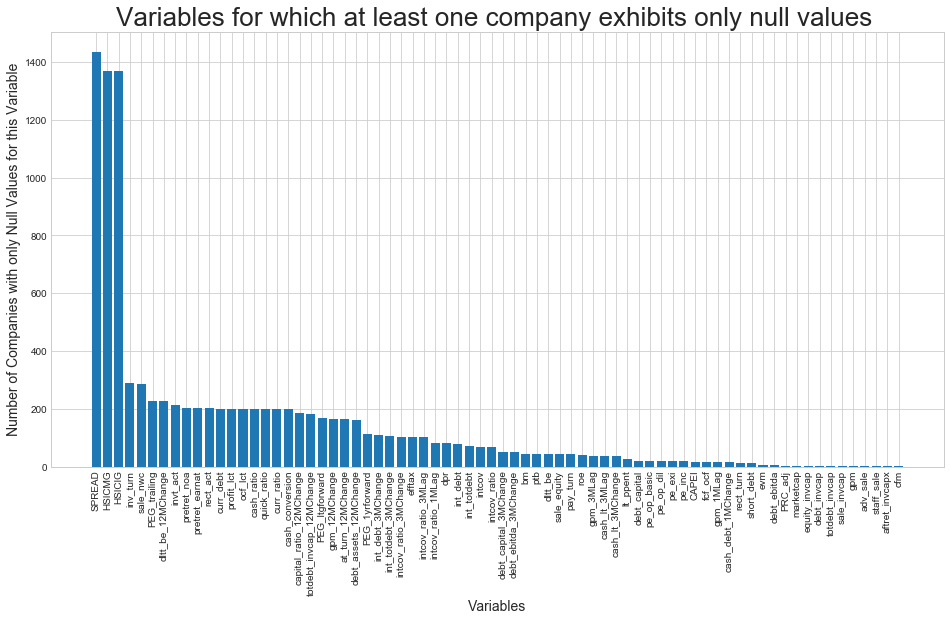

In [38]:
# plotting the variables for which at least one company exhibits only null values 
plt.figure(figsize=(16, 8));
plt.bar([variable[0] for variable in var_w_comp_that_are_null_unique_sorted], \
        [variable[1] for variable in var_w_comp_that_are_null_unique_sorted]);
plt.xticks(rotation=90);
plt.title('Variables for which at least one company exhibits only null values ', fontsize=26);
plt.xlabel('Variables', fontsize=14);
plt.ylabel('Number of Companies with only Null Values for this Variable', fontsize=14);


In [39]:
# create a data frame for which variables and companies will be dropped
data_without_nulls = data_w_nulls.copy()

### 5.3.2 Dropping the worst Variables

In [40]:
# select threshold for cutting variables depending on # companies that have null values for this variable (n)
n = 200
variables_threshold = 0
for e in [i[1] for i in var_w_comp_that_are_null_unique_sorted]:
    if e>=n:
        variables_threshold += 1
    else:
        break

# creating a list of the poorest variables
poorest_variables = [i[0] for i in var_w_comp_that_are_null_unique_sorted][:variables_threshold]

print('The selected threshold of ' + str(n) + ' demands dropping the first (worst) ' + \
      str(variables_threshold) + ' variables, which are:\n ' + str(poorest_variables))

# dropping the worst variables based on calculated threshold
data_without_nulls.drop(columns=poorest_variables, inplace=True)

The selected threshold of 200 demands dropping the first (worst) 17 variables, which are:
 ['SPREAD', 'HSICMG', 'HSICIG', 'inv_turn', 'sale_nwc', 'PEG_trailing', 'dltt_be_12MChange', 'invt_act', 'pretret_noa', 'pretret_earnat', 'rect_act', 'curr_debt', 'profit_lct', 'ocf_lct', 'cash_ratio', 'quick_ratio', 'curr_ratio']


## 5.4 Dealing with Observations

### 5.4.1 Assessment of the Null Values for each Company

In [41]:
companies_w_null_variables = []
for company in set([entry[0] for entry in data_without_nulls.index.tolist()]):
    for column in data_without_nulls:
        if data_without_nulls.xs(company, level='PERMNO')[column].isnull().values.any():
            companies_w_null_variables.append(company)

# sort the companies descending by the number of variables with only null values
companies_w_null_variables_unique_sorted = Counter(companies_w_null_variables).most_common()

# check which of the companies with variables that are null are in the SP500:
is_in_SP500 = []
for tup in Counter(companies_w_null_variables).most_common():
    is_in_SP500.append(tup[0] in list(SP500_company_list.PERMNO))

In [42]:
nr_of_companies = len(set([entry[0] for entry in data_without_nulls.index.tolist()]))
print('There are ' + str(nr_of_companies) + ' companies in the dataset.')
print(str(Counter(is_in_SP500)[True] + Counter(is_in_SP500)[False])\
      + ' companies have at least one variable with only null values.')

print(str(Counter(is_in_SP500)[True]) + ' of those companies are in the SP500.')
print(str(Counter(is_in_SP500)[False]) + ' of those companies are not in the SP500.')
      
print('Thus there are '\
      + str(nr_of_companies - len(companies_w_null_variables_unique_sorted))\
      + ' companies with no null variables left.')
print('Of those, '\
      + str(len(list(SP500_company_list.PERMNO)) - Counter(is_in_SP500)[True])\
      + ' are in the SP500.')

There are 1437 companies in the dataset.
531 companies have at least one variable with only null values.
85 of those companies are in the SP500.
446 of those companies are not in the SP500.
Thus there are 906 companies with no null variables left.
Of those, 430 are in the SP500.


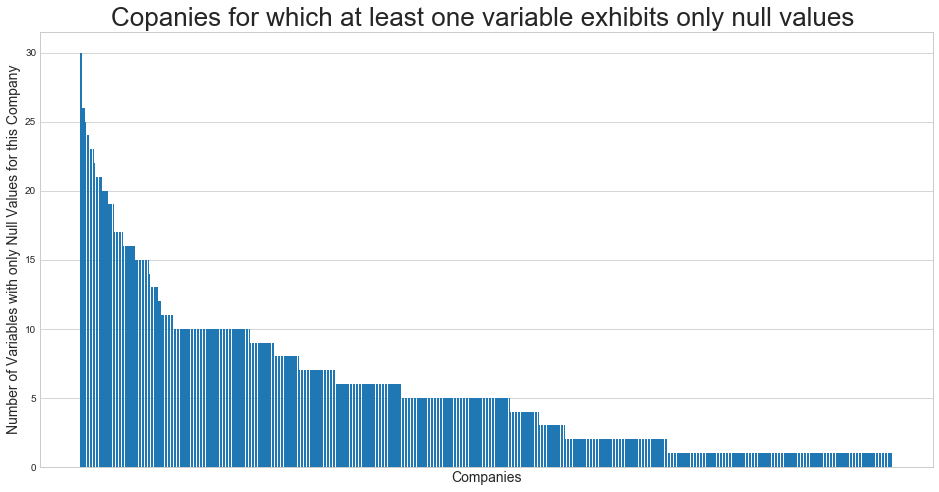

In [43]:
# plotting the companies for which most variables exhibit only null values
plt.figure(figsize=(16, 8));
plt.bar([str(company[0]) for company in companies_w_null_variables_unique_sorted], \
        [company[1] for company in companies_w_null_variables_unique_sorted]);
plt.xticks([]);
plt.title('Copanies for which at least one variable exhibits only null values ', fontsize=26);
plt.xlabel('Companies', fontsize=14);
plt.ylabel('Number of Variables with only Null Values for this Company', fontsize=14);

### 5.4.2 Dropping Companies that still exhibit Null Values

In [44]:
# create a list of the codes of the companies to drop
companies_to_drop = [tup[0] for tup in companies_w_null_variables_unique_sorted]

# drop those companies
data_without_nulls.drop(index=companies_to_drop, level='PERMNO', inplace=True)

# check if there are any null values left
if data_without_nulls.isna().sum().sum() == 0:
    print('There are no null values left in the DataFrame "data_without_nulls".')

There are no null values left in the DataFrame "data_without_nulls".


## 5.5 Comparing the cleaned with uncleaned Data Frame

In [45]:
# copy dataframe
cleaned_data = data_without_nulls.copy()

# sort dataframe
cleaned_data.sort_index(inplace=True)

# comparison
print(str(round(cleaned_data.shape[0] / data_w_dummies.shape[0] * 100, 2)) + \
      ' % of the observations remain.')
print(str(round(cleaned_data.shape[1] / data_w_dummies.shape[1] * 100, 2)) + \
      ' % of the variables remain.')

26.45 % of the observations remain.
91.75 % of the variables remain.


# 6 Transforming the Response Variable 

## 6.1 Exploring the Ratings Distribution

In [46]:
# determine the rating frequencies
rating_frequencies = Counter(cleaned_data.splticrm).most_common()

# display the five ratings with the fewest observations
print('The least frequent ratings (rating, frequency) are:\n' + \
      str(rating_frequencies[-7:][::-1]))

The least frequent ratings (rating, frequency) are:
[('CCC-', 19), ('SD', 25), ('CC', 25), ('D', 25), ('CCC', 97), ('AA+', 132), ('AAA', 206)]


## 6.2 Combine Categories with few Observations into one Category

In [47]:
cleaned_data["splticrm"] = ['CCC or lower' if r in ['CCC', 'CCC-', 'CC', 'SD', 'D'] \
                            else r for r in cleaned_data["splticrm"].tolist()]

## 6.3 Convert splticrm into an Ordered Categorical Variable

In [48]:
# Order splticrm variable
splticrm_categories = pd.CategoricalDtype(categories=[
    'CCC or lower', 'CCC+', 'B-', 'B', 'B+', 'BB-', 'BB', 'BB+', 'BBB-', 'BBB', 'BBB+',
    'A-', 'A', 'A+', 'AA-', 'AA', 'AA+', 'AAA'], ordered=True)

# Transfer ordered categories to splticrm
cleaned_data["splticrm"] = cleaned_data["splticrm"].astype(splticrm_categories)

## 6.4 Check the Distribution of the splticrm Variable

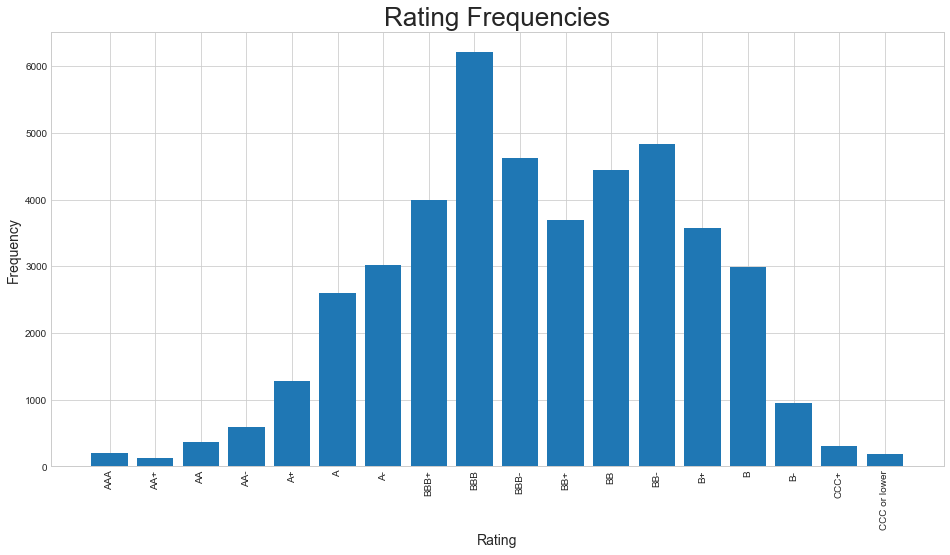

In [49]:
# determine the rating frequencies and sort them by category
ratings_sorted_list = splticrm_categories.categories.tolist()[::-1]
ratings_sort_order = dict(zip(ratings_sorted_list, list(range(len(ratings_sorted_list)))))
rating_frequencies = Counter(cleaned_data.splticrm)
ratings_to_sort = [list(r) for r in zip(list(rating_frequencies.keys()), \
                                        list(rating_frequencies.values()))]
rating_frequencies = sorted(ratings_to_sort, key=lambda val: ratings_sort_order[val[0]])

# plot distributions of ratings
_ = plt.figure(figsize=(16, 8));
_ = plt.bar([rating[0] for rating in rating_frequencies], \
            [frequency[1] for frequency in rating_frequencies]);
_ = plt.title('Rating Frequencies', fontsize=26);
_ = plt.xlabel('Rating', fontsize=14);
_ = plt.ylabel('Frequency', fontsize=14);
_ = plt.xticks(rotation=90);
plt.show();

In [50]:
# save cleaned data frame to file
cleaned_data.to_csv('data/cleaned_data.csv')

# 7 Principal Component Analysis for Dimensionality Reduction

## 7.1 Applying PCA

In [51]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# select dataset you want to look at
data_PCA = cleaned_data.copy()

# take out variable 'splticrm'
y = data_PCA['splticrm']
data_PCA.drop(columns=['splticrm'], inplace=True)

# scale data
scaler = StandardScaler()
data_PCA = scaler.fit_transform(data_PCA)

# instantiate and fit pca object
PCA = PCA()
_ = PCA.fit(data_PCA);

## 7.2 Plotting Explained Variance

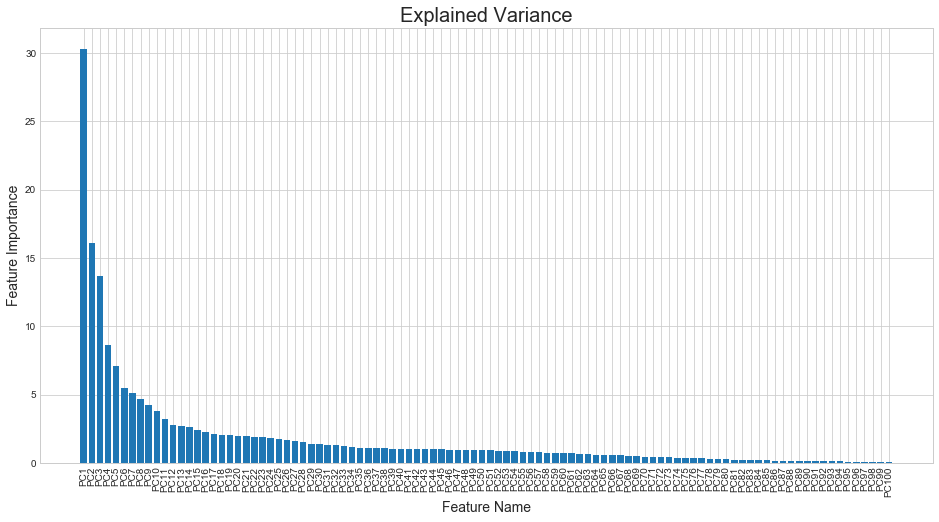

In [52]:
# creating list with names for principal components
PC_names = ['PC' + str(i) for i in np.arange(1, data_PCA.shape[1] + 1)]

# plot the first 10 PCs and the variance they explain
_ = plt.figure(figsize=(16, 8));
_ = plt.bar(PC_names[:100], PCA.explained_variance_[:100]);
_ = plt.title('Explained Variance', fontsize=20);
_ = plt.xlabel('Feature Name', fontsize=14);
_ = plt.ylabel('Feature Importance', fontsize=14);
_ = plt.xticks(rotation=90)
plt.show();

## 7.3 Cumulative and Total Explained Variance

Use up to PC67 to explain at least 95.0% of the total variance.
The PCs up to PC67 will explain 95.16% of the total variance.


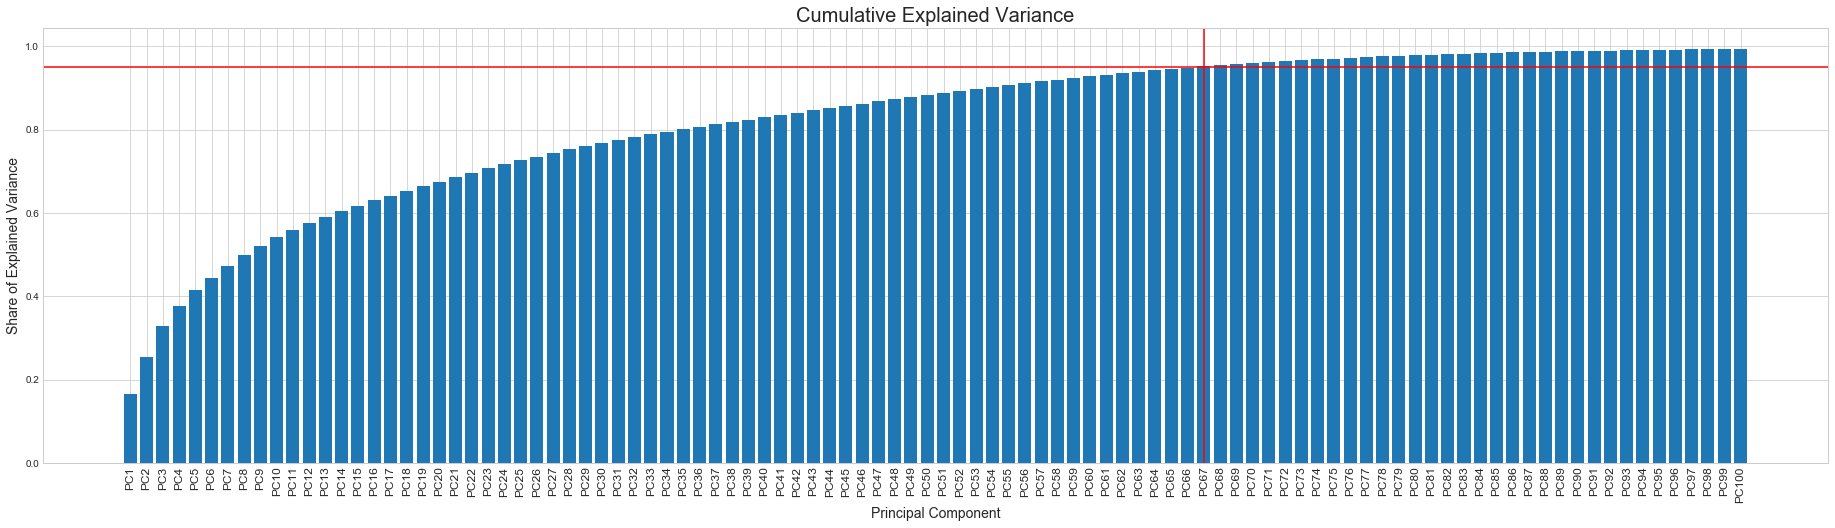

In [53]:
# calculate cumulative and total explained variance
cumulative_explained_variance = np.cumsum(PCA.explained_variance_)
total_variance = cumulative_explained_variance[-1]
adjusted_cumulative_explained_variance = cumulative_explained_variance / total_variance

# specify threshold to look at
PCA_threshold = 0.95

# indices of first pc over specified threshold
first_PC_over_threshold_indices = np.where(adjusted_cumulative_explained_variance \
                                    >= PCA_threshold)[0][0]
first_PCs = 'PC' + str(first_PC_over_threshold_indices + 1)

print('Use up to ' + str(first_PCs) + ' to explain at least ' + \
      str(PCA_threshold * 100) + '% of the total variance.')
print('The PCs up to ' + str(first_PCs) + ' will explain ' + \
      str(round(adjusted_cumulative_explained_variance[first_PC_over_threshold_indices] * 100, 2)) + \
      '% of the total variance.')

# plot cumulative explained variance of first 100 PCs
plt.figure(figsize=(32,8));
plt.bar(PC_names[:100], adjusted_cumulative_explained_variance[:100]);
plt.xticks(rotation=90, fontsize=12);
plt.title('Cumulative Explained Variance', fontsize=20);
plt.xlabel('Principal Component', fontsize=14);
plt.ylabel('Share of Explained Variance', fontsize=14);
plt.axhline(PCA_threshold, color='red');
plt.axvline(first_PCs, color='red');

# 8 Determining Feature Importances

## 8.1 Exploring Features with only Unique Entries

In [54]:
# considering only companies that are in the SP500
data_SP500 = cleaned_data.copy()[cleaned_data['in_sp500'] == 1]

# determine the number of different entries
nr_of_unique_entries = [(feature, len(Counter(data_SP500[feature]))) \
                        for feature in data_SP500.columns.values.tolist()]

# determine the features with only one value for both data frames
features_w_only_one_entry = []
for feature in nr_of_unique_entries:
    if feature[1] == 1:
        features_w_only_one_entry.append(feature[0])

# print the features that contain only one value
print('The features that have only one entry and are dropped are:\n' + \
      str(features_w_only_one_entry))

# drop those features since they do not contain any information that would be helpful
data_SP500.drop(columns=features_w_only_one_entry, inplace=True)

The features that have only one entry and are dropped are:
['SHRCD', 'in_sp500', 'R', 'H', 'S', 'St. Tammany', 'Real Estate']


## 8.2 Separating Features & Responses and Testing & Training Data

In [55]:
# convert splticrm back to string on the s&p500 subset, since RF might not accept it
data_SP500.splticrm = data_SP500.splticrm.astype('str')

# separate features and responses into separate variables
features, responses = data_SP500.drop(columns=['splticrm'], inplace=False), \
    data_SP500.splticrm.copy()

# splitting taining and testing data
features_train, features_test, responses_train, responses_test = \
    train_test_split(features, responses, test_size = 0.2, random_state = 0)

# ensuring the splitting is in line with the chosen relative training data size
training_size = features_train.shape[0] / (features_train.shape[0] + features_test.shape[0])
print('The training set contains ' + str(round(100 * training_size, 1)) + ' % of the data.')

The training set contains 80.0 % of the data.


In [56]:
# imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# creating a pipeline for random forests
randomForest = RandomForestClassifier(random_state=0)

# fitting the random forest grid
_ = randomForest.fit(features_train, responses_train)

## 8.3 Plotting the Feature Importances

In [57]:
# get the feature names
feature_names = features_train.columns

# extract the feature importances of the best model
best_feature_importances = randomForest.feature_importances_

# create a dictionary with the feature names and importances
feature_importances_dict = dict(zip(feature_names, best_feature_importances))

# sort the dictionary descending
feature_importances_sorted = sorted(feature_importances_dict.items(), \
                                         key=lambda x: x[1], reverse=True)

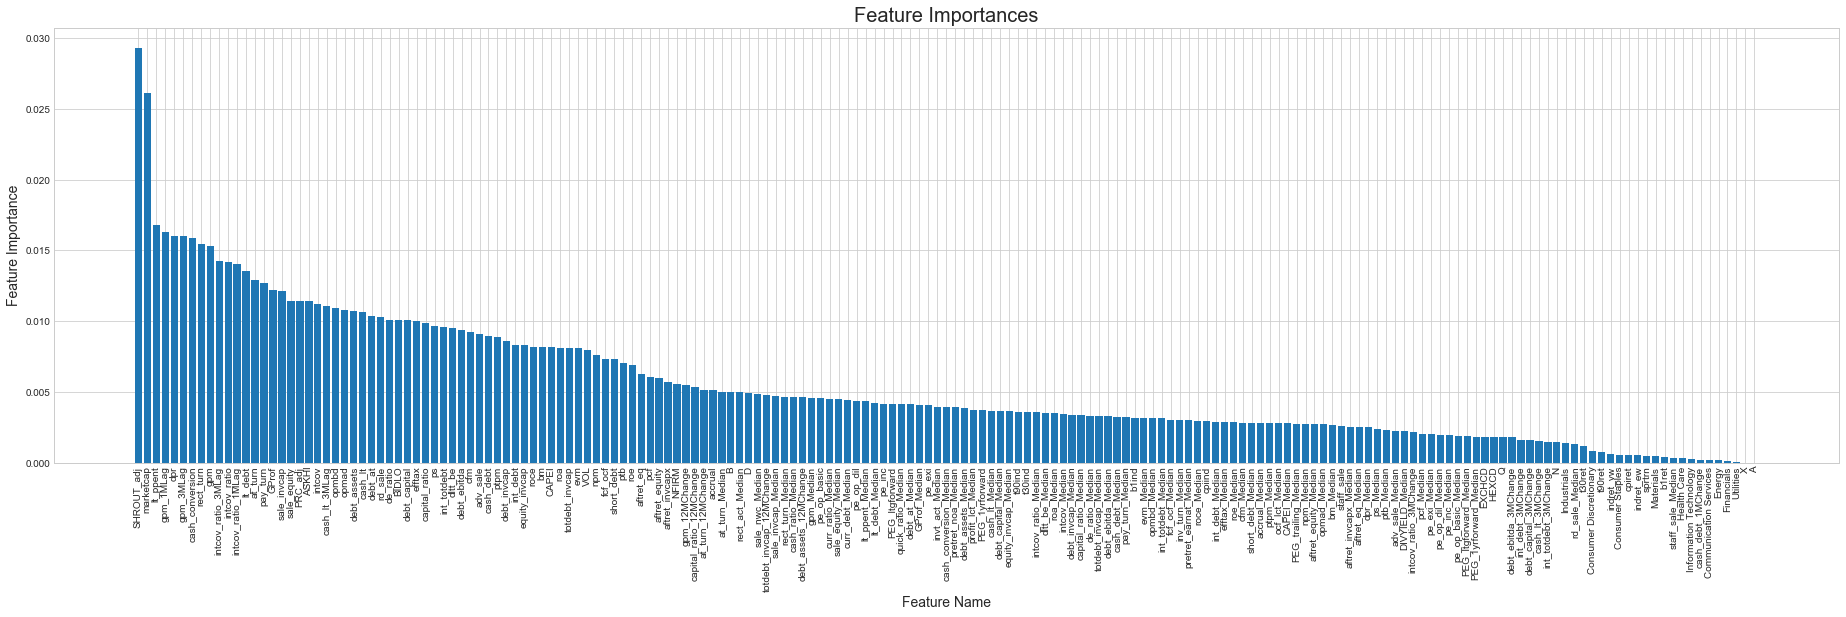

In [58]:
# plot the feature importances
_ = plt.figure(figsize=(32, 8));
_ = plt.bar(list(zip(*feature_importances_sorted))[0], \
            list(zip(*feature_importances_sorted))[1]);
_ = plt.title('Feature Importances', fontsize=20);
_ = plt.xlabel('Feature Name', fontsize=14);
_ = plt.ylabel('Feature Importance', fontsize=14);
_ = plt.xticks(rotation=90)
plt.show();

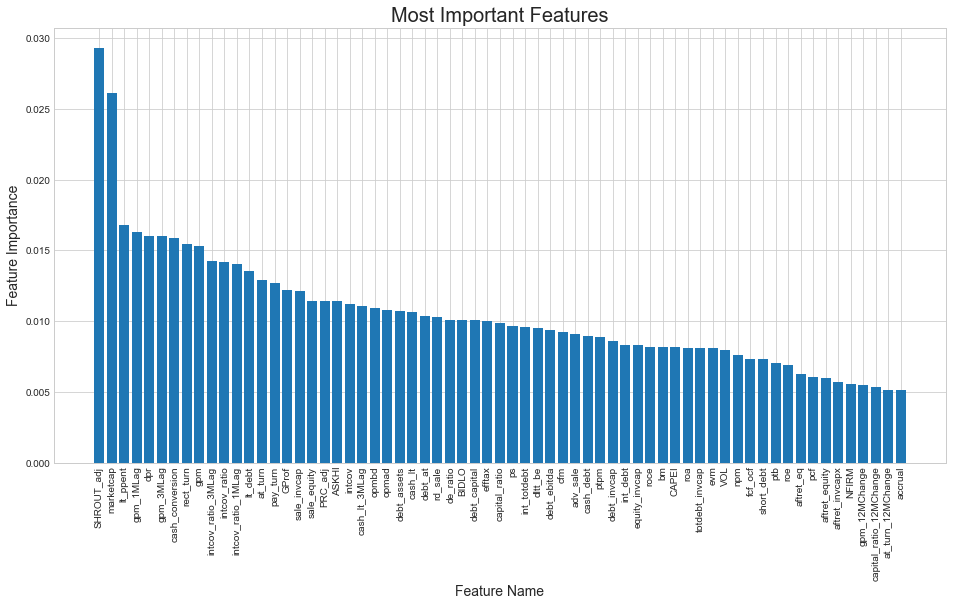

In [59]:
# create plot for mean feature imporances until crease in importance reduction
importance_threshold = 0.005
features_counter = 0
for importance in list(zip(*feature_importances_sorted))[1]:
    if importance > importance_threshold:
        features_counter += 1
    else:
        break

_ = plt.figure(figsize=(16, 8));
_ = plt.bar(list(zip(*feature_importances_sorted))[0][:features_counter], \
            list(zip(*feature_importances_sorted))[1][:features_counter]);
_ = plt.title('Most Important Features', fontsize=20);
_ = plt.xlabel('Feature Name', fontsize=14);
_ = plt.ylabel('Feature Importance', fontsize=14);
_ = plt.xticks(rotation=90)
plt.show();

## 8.4 Save a File containing the Best Features

In [60]:
# copy data that has only the top features
data_top_features = data_SP500.copy()
data_top_features.drop(columns=list(list(zip(*feature_importances_sorted))\
                                      [0][features_counter:]), inplace=True)

# save dataframe
data_top_features.to_csv('data/data_top_features.csv')

print('The ' + str(data_top_features.shape[1]) + ' best features were saved.')

The 66 best features were saved.
